In [1]:
%load_ext autoreload
%autoreload 2
import os, argparse, random, math, sys, pickle, scipy, sys
from scipy.stats import bootstrap
import pandas as pd
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import bootstrap
plt.rcParams["font.family"] = "Serif"
sys.path.append("..")
from data.simulation import generate_synthetic_nc_rate, generate_synthetic_nc_effect

In [2]:
def get_full_eval_df(num_reps_start, num_reps_end, checkpoint_dir, model): 
    eval_df = []
    for rep in range(num_reps_start, num_reps_end):
        curr_cp_dir = os.path.join(checkpoint_dir, f"rep={rep}", model)
        curr_eval_path = os.path.join(curr_cp_dir, f"eval.csv")
        assert os.path.isfile(curr_eval_path), curr_eval_path
        curr_eval_df = pd.read_csv(curr_eval_path)
        curr_eval_df["rep"] = rep
        eval_df.append(curr_eval_df)
    eval_df = pd.concat(eval_df)
    return eval_df    
tlearner_map_dict = {"sbd-tlearner": "SBD", "cfd-tlearner": "CFD"}

### Results for Synthetic Dataset A

In [3]:
num_reps=20
n=1000
p=30
u_ay = 0
u_ty = 0
amp=10
nc_types = ["one-sided", "two-sided"]
nc_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] + [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]
model_strs = ["sbd-tlearner", "cfd-tlearner"]
delta_A_df = {"nc_type": [], "nc_rate": [], "rep": [], "delta_A": []}
for nc_type in nc_types:
    for nc_rate in tqdm(nc_rates): 
        for rep in range(num_reps):
            train_df, test_df = generate_synthetic_nc_rate(
                    n=n, p=p, rep=rep, nc_rate=nc_rate, amplitude=amp,
                    nc_type=nc_type, num_u_ty=u_ty, num_u_ay=u_ay
            )
            delta_A = np.abs(np.mean(test_df["A_T1"] - test_df["A_T0"]))
            delta_A_df["nc_type"].append(nc_type)
            delta_A_df["nc_rate"].append(nc_rate)
            delta_A_df["rep"].append(rep)
            delta_A_df["delta_A"].append(delta_A)
delta_A_df = pd.DataFrame(delta_A_df)
delta_A_df = delta_A_df.drop(columns=["rep"]).groupby(["nc_type", "nc_rate"]).mean().reset_index()

os_nc_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ts_nc_rates = [0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9] + [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]
eval_df_list = []
for nc_type in nc_types:
    if nc_type == "one-sided":
        nc_rates = os_nc_rates
    elif nc_type == "two-sided":
        nc_rates = ts_nc_rates
    for nc_rate in tqdm(nc_rates): 
        for model in model_strs:
            sim_rate_checkpoint_dir = os.path.join("..", "..", "checkpoints", 
                f"Synthetic-rate", f"n={n}_p={p}_amp={amp}", f"Uay={u_ay}_Uty={u_ty}", 
                f"type={nc_type}", f"rate={nc_rate}")
            assert os.path.isdir(sim_rate_checkpoint_dir), sim_rate_checkpoint_dir
            sim_rate_eval_df = get_full_eval_df(0, num_reps, sim_rate_checkpoint_dir, model)
            sim_rate_eval_df["nc_type"] = nc_type
            sim_rate_eval_df["nc_rate"] = nc_rate
            sim_rate_eval_df["model"] = model
            eval_df_list.append(sim_rate_eval_df)

sim_rate_eval_df = pd.concat(eval_df_list)
sim_rate_eval_df.model = sim_rate_eval_df.model.map(tlearner_map_dict)
sim_rate_eval_df = sim_rate_eval_df.merge(delta_A_df, on=["nc_type", "nc_rate"], how="left")

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:08<00:00,  2.19it/s]


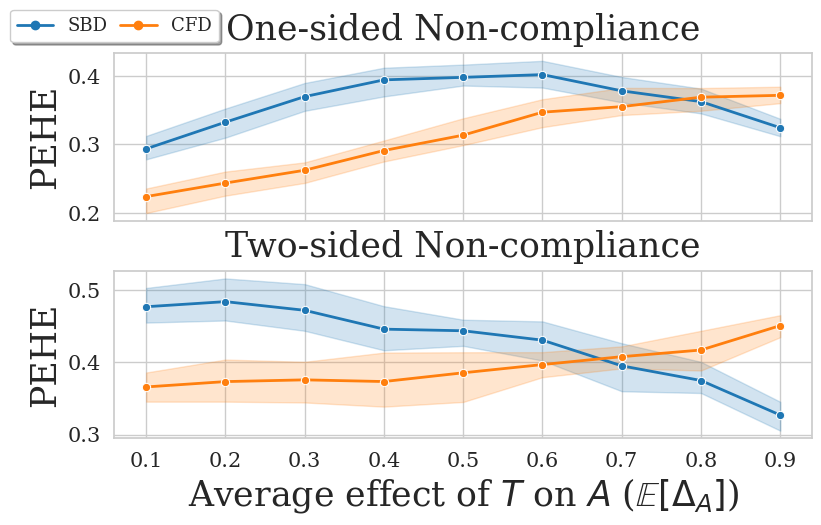

In [4]:
sns.set(font="Serif", style="whitegrid", rc={"lines.linewidth": 2.0})
palette = sns.color_palette(['tab:blue', 'tab:orange'])
fig = plt.figure(figsize=(10*0.9, 5))
gs = fig.add_gridspec(2, 1, hspace=0.3, wspace=0.08)
axes = gs.subplots(sharex='col')

subset_sim_rate_eval_df = sim_rate_eval_df.copy()
subset_sim_rate_eval_df.nc_rate = (subset_sim_rate_eval_df.nc_rate * 100).map(lambda x: f"{int(x)}%")
subset_sim_rate_eval_df["delta_A"] = subset_sim_rate_eval_df["delta_A"].round(decimals=1)
sns.lineplot(data=subset_sim_rate_eval_df[(subset_sim_rate_eval_df.label=="assign effect PEHE") & (subset_sim_rate_eval_df.nc_type=="one-sided")], 
              x="delta_A", y="value", hue="model", style="model", ax=axes[0], errorbar=lambda x: np.percentile(x, (25, 75)), estimator="mean", 
              dashes=False, markers=["o", "o"], palette=palette)
sns.lineplot(data=subset_sim_rate_eval_df[(subset_sim_rate_eval_df.label=="assign effect PEHE") & (subset_sim_rate_eval_df.nc_type=="two-sided")], 
              x="delta_A", y="value", hue="model", style="model", ax=axes[1], errorbar=lambda x: np.percentile(x, (25, 75)), estimator="mean", 
              dashes=False, markers=["o", "o"], palette=palette)

axes[0].set_title(r"One-sided Non-compliance", fontsize=25, pad=10)
axes[1].set_title(r"Two-sided Non-compliance", fontsize=25, pad=10)
axes[0].tick_params(axis='both', which='major', labelsize=15)
axes[1].tick_params(axis='both', which='major', labelsize=15)
axes[0].set_xlabel(None)
axes[1].set_xlabel(r"Average effect of $T$ on $A$ ($\mathbb{E}[\Delta_A]$)", fontsize=25)
for ax in axes.flatten(): ax.get_legend().remove()
axes[0].set_ylabel("PEHE", fontsize=25)
axes[1].set_ylabel("PEHE", fontsize=25)
fig.legend(*axes[0].get_legend_handles_labels(), loc='upper center', bbox_to_anchor=(0.125, 0.985), ncol=2, fancybox=True, shadow=True, 
           prop={'family': "Serif", 'size':13}, columnspacing=0.7)

### Results for Synthetic Dataset B

In [5]:
# load synthetic-effect experiments
num_reps=20
n=1000
p=30
amp=10
u_ay = 0
u_ty = 0
nc_types = ["one-sided", "two-sided"]
effects = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 10.0, 12.0, 20.0]
model_strs = ["sbd-tlearner", "cfd-tlearner"]

In [6]:
delta_Y_df = {"nc_type": [], "effect": [], "rep": [], "delta_Y": []}
for nc_type in nc_types:
    for effect in tqdm(effects): 
        for rep in range(num_reps):
            train_df, test_df = generate_synthetic_nc_effect(
                n=n, p=p, rep=rep, effect=effect, nc_type=nc_type, amplitude=amp)
            delta_Y = np.abs(np.mean(test_df["Y_A1"] - test_df["Y_A0"]))
            delta_Y_df["nc_type"].append(nc_type)
            delta_Y_df["effect"].append(effect)
            delta_Y_df["rep"].append(rep)
            delta_Y_df["delta_Y"].append(delta_Y)
delta_Y_df = pd.DataFrame(delta_Y_df)
delta_Y_df = delta_Y_df.drop(columns=["rep"]).groupby(["nc_type", "effect"]).mean().reset_index()

eval_df_list = []
for nc_type in nc_types:
    for effect in tqdm(effects): 
        for model in model_strs:
            sim_rate_checkpoint_dir = os.path.join("..", "..", "checkpoints", 
                f"Synthetic-effect", f"n={n}_p={p}_amp={amp}", f"type={nc_type}", f"effect={effect}")
            assert os.path.isdir(sim_rate_checkpoint_dir), sim_rate_checkpoint_dir
            sim_effect_eval_df = get_full_eval_df(0, num_reps, sim_rate_checkpoint_dir, model)
            sim_effect_eval_df["nc_type"] = nc_type
            sim_effect_eval_df["effect"] = effect
            sim_effect_eval_df["model"] = model
            eval_df_list.append(sim_effect_eval_df)

sim_effect_eval_df = pd.concat(eval_df_list)
sim_effect_eval_df.model = sim_effect_eval_df.model.map(tlearner_map_dict)
sim_effect_eval_df = sim_effect_eval_df.merge(delta_Y_df, on=["nc_type", "effect"], how="left")

 18%|█▊        | 2/11 [00:00<00:01,  5.60it/s]

100%|██████████| 11/11 [00:03<00:00,  2.86it/s]


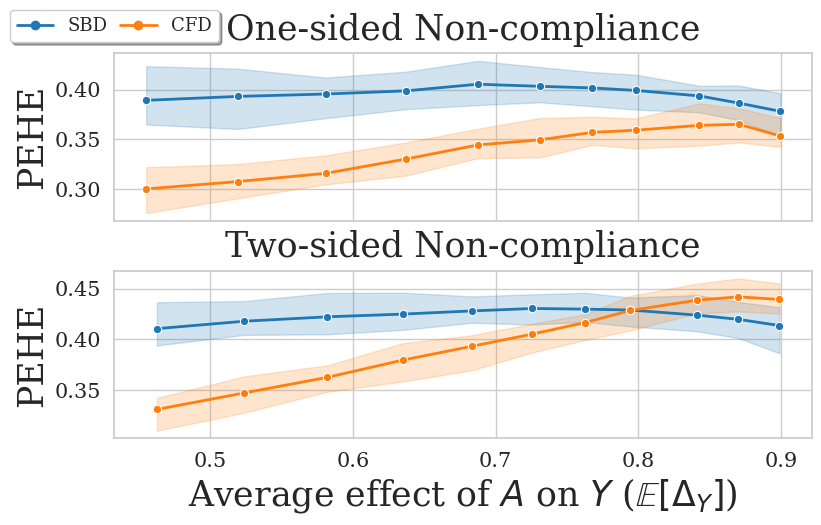

In [7]:
sns.set(font="Serif", style="whitegrid", rc={"lines.linewidth": 2.0})
fig = plt.figure(figsize=(10*0.9, 5))
gs = fig.add_gridspec(2, 1, hspace=0.3, wspace=0.08)
axes = gs.subplots(sharex='col')
palette = sns.color_palette(['tab:blue', 'tab:orange'])

subset_sim_effect_eval_df = sim_effect_eval_df.copy()
subset_sim_effect_eval_df["delta_Y"] = subset_sim_effect_eval_df["delta_Y"]#.round(decimals=3)
sns.lineplot(data=subset_sim_effect_eval_df[(subset_sim_effect_eval_df.label=="assign effect PEHE") & (subset_sim_effect_eval_df.nc_type=="one-sided")], 
              x="delta_Y", y="value", hue="model", style="model", ax=axes[0],  errorbar=lambda x: np.percentile(x, (25, 75)), estimator="mean", 
              markers=["o", "o"], dashes=False, palette=palette),
sns.lineplot(data=subset_sim_effect_eval_df[(subset_sim_effect_eval_df.label=="assign effect PEHE") & (subset_sim_effect_eval_df.nc_type=="two-sided")], 
              x="delta_Y", y="value", hue="model", style="model", ax=axes[1], errorbar=lambda x: np.percentile(x, (25, 75)), estimator="mean", 
              markers=["o", "o"], dashes=False, palette=palette)

axes[0].set_title(r"One-sided Non-compliance", fontsize=25, pad=10)
axes[1].set_title(r"Two-sided Non-compliance", fontsize=25, pad=10)
axes[0].tick_params(axis='both', which='major', labelsize=15)
axes[1].tick_params(axis='both', which='major', labelsize=15)
axes[0].set_xlabel(None)
axes[1].set_xlabel(r"Average effect of $A$ on $Y$ ($\mathbb{E}[\Delta_Y]$)", fontsize=25)
for ax in axes.flatten():
    ax.get_legend().remove()
axes[0].set_ylabel("PEHE", fontsize=25)
axes[1].set_ylabel("PEHE", fontsize=25)
fig.legend(*axes[0].get_legend_handles_labels(), loc='upper center', bbox_to_anchor=(0.125, 0.985), ncol=2, fancybox=True, shadow=True, 
           prop={'family': "Serif", 'size':13}, columnspacing=0.7)

### Quantitative Results

In [8]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

# compute overall mean and CI for sim rate experiment
print(f"Overall PEHE mean and CI for Synthetic Data A")
for nc_type in ["one-sided", "two-sided"]:
    print(f"\t{nc_type}")
    for method in ["SBD", "CFD"]:
        print(f"\t\t{method}-based methods: ", end="")
        curr_obs = sim_rate_eval_df[(sim_rate_eval_df.nc_type==nc_type) & 
                (sim_rate_eval_df.model.str.startswith(method)) & (sim_rate_eval_df.label=="assign effect PEHE")].value.values.reshape(1, -1)
        mean = np.mean(curr_obs)
        ci = bootstrap(curr_obs, np.mean, n_resamples=1000).confidence_interval
        ci_pm = (ci.high - ci.low)/2
        print(f"{mean:.3f} $\pm$ {ci_pm:.3f}")
print()

print(f"Overall PEHE mean and CI for Synthetic Data B")
for nc_type in ["one-sided", "two-sided"]:
    print(f"\t{nc_type}")
    for method in ["SBD", "CFD"]:
        print(f"\t\t{method}-based methods: ", end="")
        curr_obs = sim_effect_eval_df[(sim_effect_eval_df.nc_type==nc_type) & 
                (sim_effect_eval_df.model.str.startswith(method)) & (sim_effect_eval_df.label=="assign effect PEHE")].value.values.reshape(1, -1)
        mean = np.mean(curr_obs)
        ci = bootstrap(curr_obs, np.mean, n_resamples=1000).confidence_interval
        ci_pm = (ci.high - ci.low)/2
        print(f"{mean:.3f} $\pm$ {ci_pm:.3f}")


Overall PEHE mean and CI for Synthetic Data A
	one-sided
		SBD-based methods: 0.362 $\pm$ 0.007
		CFD-based methods: 0.309 $\pm$ 0.009
	two-sided
		SBD-based methods: 0.428 $\pm$ 0.007
		CFD-based methods: 0.394 $\pm$ 0.005

Overall PEHE mean and CI for Synthetic Data B
	one-sided
		SBD-based methods: 0.395 $\pm$ 0.005
		CFD-based methods: 0.341 $\pm$ 0.004
	two-sided
		SBD-based methods: 0.423 $\pm$ 0.004
		CFD-based methods: 0.398 $\pm$ 0.006
